In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import joblib

In [26]:
# 1. Load dataset
df = pd.read_csv("chatgpt_style_reviews_dataset.xlsx - Sheet1.csv")

In [27]:
# 2. Clean text (loop instead of lambda/def)
cleaned_reviews = []
for text in df['review']:
    text = str(text).lower()                        # lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)           # keep only letters
    text = re.sub(r'\s+', ' ', text).strip()        # remove extra spaces
    cleaned_reviews.append(text)

df['review_clean'] = cleaned_reviews

In [28]:
# 3. Map rating → sentiment (loop instead of lambda/def)
sentiments = []
for r in df['rating']:
    if r >= 4:
        sentiments.append("positive")
    elif r == 3:
        sentiments.append("neutral")
    else:
        sentiments.append("negative")

df['sentiment'] = sentiments


In [29]:
# 4. Save cleaned dataset
df.to_csv("cleaned_reviews.csv", index=False)
print(df[['review', 'review_clean', 'sentiment']].head())

                                              review  \
0  Impressive natural language understanding. Alm...   
1  Sometimes gives wrong answers or outdated info...   
2  Great tool for generating content quickly. Int...   
3  Great tool for generating content quickly. Sta...   
4  Excellent for language translation and grammar...   

                                        review_clean sentiment  
0  impressive natural language understanding almo...  negative  
1  sometimes gives wrong answers or outdated info...  negative  
2  great tool for generating content quickly inte...  positive  
3  great tool for generating content quickly star...   neutral  
4  excellent for language translation and grammar...  negative  


In [30]:
df = pd.read_csv("cleaned_reviews.csv")

# Ensure date column is datetime if exists
if "date" in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')


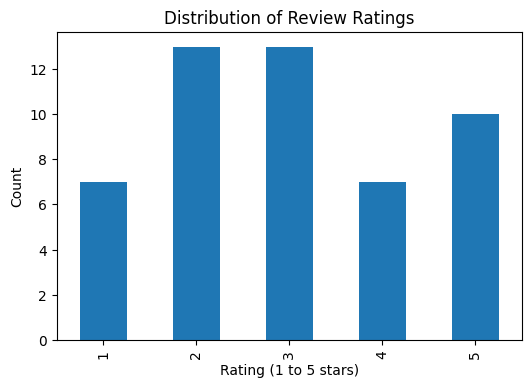

In [31]:
# 1. Rating distribution
df['rating'].value_counts().sort_index().plot(kind='bar', figsize=(6,4), color=['#1f77b4'])
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating (1 to 5 stars)")
plt.ylabel("Count")
plt.show()


d:\MDTE21\AI Echo\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MDTE21\AI Echo\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128078 (\N{THUMBS DOWN SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


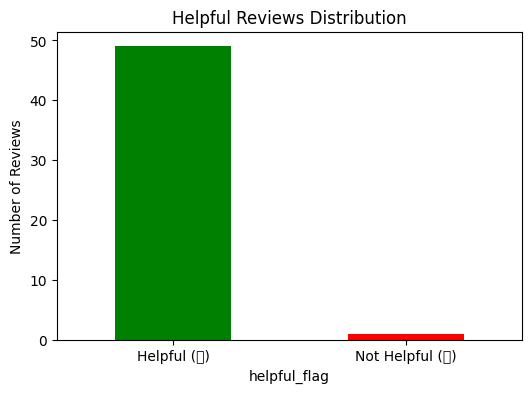

In [32]:
# -------------------------------
# 2. Helpful reviews (threshold > 10) - Alternative Bar Chart
# -------------------------------
threshold = 10
df['helpful_flag'] = df['helpful_votes'].apply(lambda x: "Helpful (👍)" if x > threshold else "Not Helpful (👎)")

helpful_counts = df['helpful_flag'].value_counts()

plt.figure(figsize=(6,4))
helpful_counts.plot(kind='bar', color=['green','red'])
plt.title("Helpful Reviews Distribution")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()


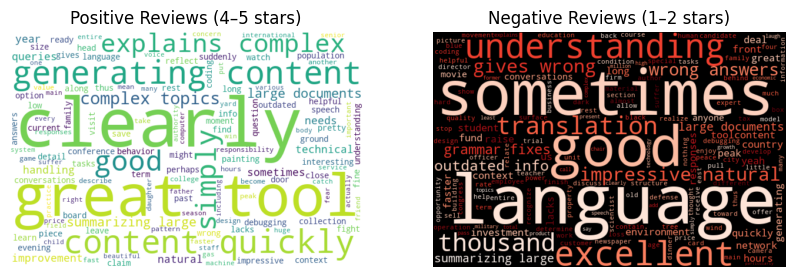

In [33]:
# -------------------------------
# 3. Word clouds for positive vs negative reviews
# -------------------------------
from wordcloud import WordCloud

positive_text = " ".join(df[df['rating'] >= 4]['review_clean'])
negative_text = " ".join(df[df['rating'] <= 2]['review_clean'])

wc_pos = WordCloud(width=600, height=400, background_color="white").generate(positive_text)
wc_neg = WordCloud(width=600, height=400, background_color="black", colormap="Reds").generate(negative_text)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews (4–5 stars)")

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews (1–2 stars)")
plt.show()

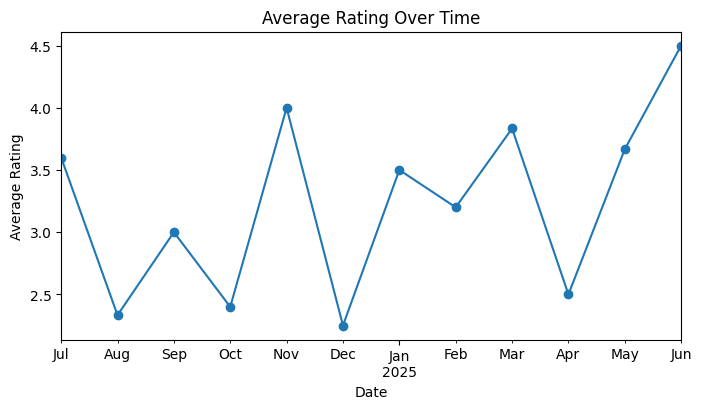

In [34]:
# 4. Average rating over time
df.groupby(df['date'].dt.to_period("M"))['rating'].mean().plot(kind='line', marker='o', figsize=(8,4))
plt.title("Average Rating Over Time")
plt.xlabel("Date"); plt.ylabel("Average Rating")
plt.show()

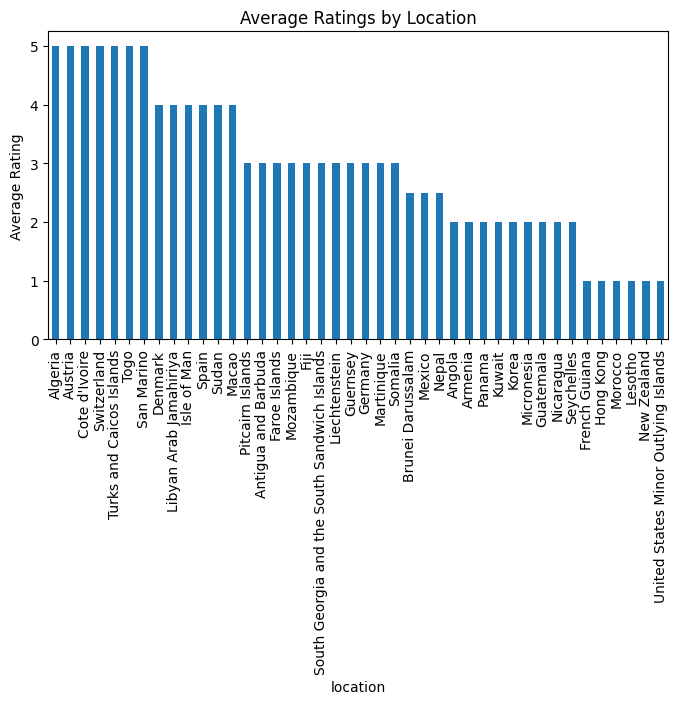

In [35]:
# 5. Ratings by location
df.groupby('location')['rating'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(8,4))
plt.title("Average Ratings by Location")
plt.ylabel("Average Rating")
plt.show()


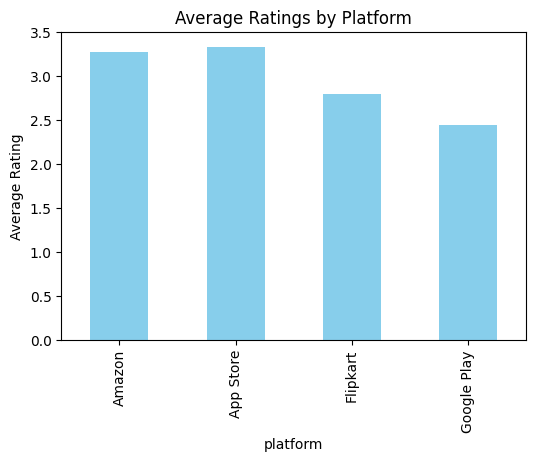

In [36]:
# 6. Ratings by platform
df.groupby('platform')['rating'].mean().plot(kind='bar', figsize=(6,4), color='skyblue')
plt.title("Average Ratings by Platform")
plt.ylabel("Average Rating")
plt.show()


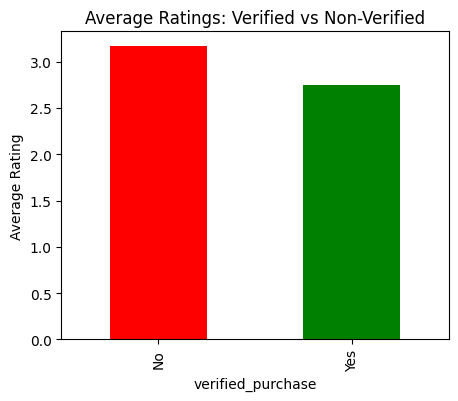

In [37]:
# 7. Verified vs Non-Verified
df.groupby('verified_purchase')['rating'].mean().plot(kind='bar', figsize=(5,4), color=['red','green'])
plt.title("Average Ratings: Verified vs Non-Verified")
plt.ylabel("Average Rating")
plt.show()

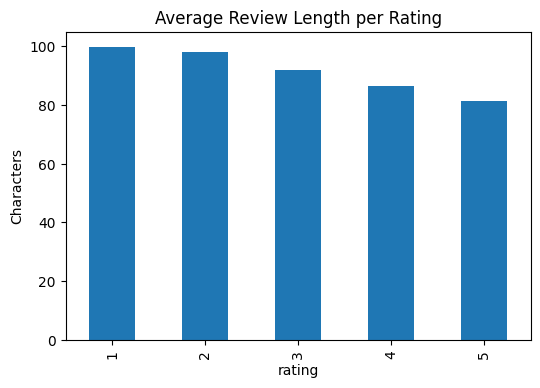

In [38]:
# 8. Review length per rating
df['review_length'] = df['review_clean'].apply(len)
df.groupby('rating')['review_length'].mean().plot(kind='bar', figsize=(6,4))
plt.title("Average Review Length per Rating")
plt.ylabel("Characters")
plt.show()

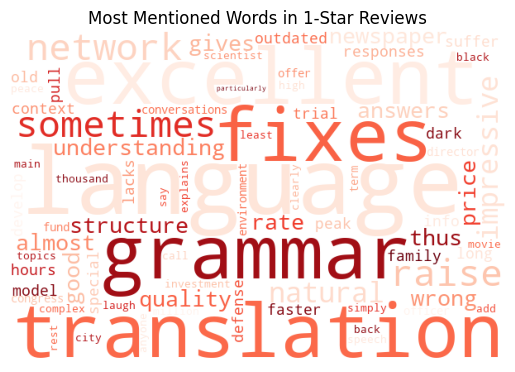

In [39]:
# 9. Word cloud for 1-star reviews
one_star_text = " ".join(df[df['rating'] == 1]['review_clean'])
wc_one = WordCloud(width=600, height=400, background_color="white", colormap="Reds").generate(one_star_text)
plt.imshow(wc_one); plt.axis("off"); plt.title("Most Mentioned Words in 1-Star Reviews")
plt.show()

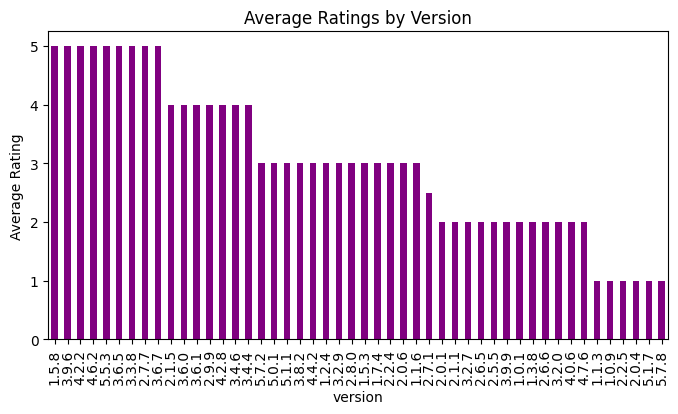

In [40]:
# 10. Ratings by version
df.groupby('version')['rating'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(8,4), color='purple')
plt.title("Average Ratings by Version")
plt.ylabel("Average Rating")
plt.show()

In [ ]:


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [42]:
# 1. Load dataset
df = pd.read_csv("cleaned_reviews.csv")

# Keep only Positive & Negative
df = df[df['sentiment'] != 'neutral']
X = df['review_clean']
y = df['sentiment']


In [43]:
# 2. TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words="english")
X_tfidf = vectorizer.fit_transform(X)

In [44]:
# 3. Oversampling to balance classes
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_tfidf, y)

In [45]:
# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

In [46]:
# -------------------------------
# 5. Train Models
# -------------------------------

# Logistic Regression
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [47]:
# -------------------------------
# 6. Evaluation Function
# -------------------------------
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=sorted(set(y_true)),
                yticklabels=sorted(set(y_true)))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


--- Logistic Regression ---
Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.50      0.60         6
    positive       0.62      0.83      0.71         6

    accuracy                           0.67        12
   macro avg       0.69      0.67      0.66        12
weighted avg       0.69      0.67      0.66        12



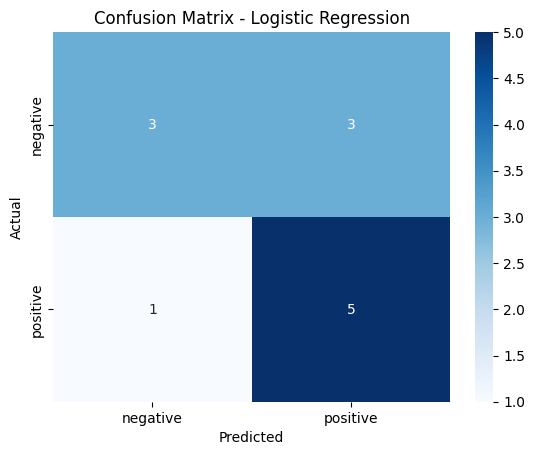


--- Random Forest ---
Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.67      0.73         6
    positive       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12



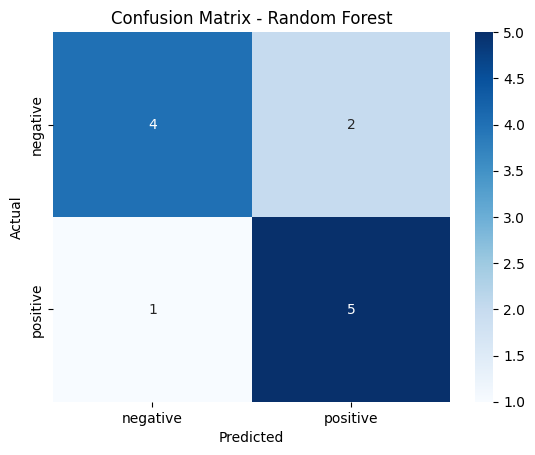


--- Naive Bayes ---
Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.50      0.60         6
    positive       0.62      0.83      0.71         6

    accuracy                           0.67        12
   macro avg       0.69      0.67      0.66        12
weighted avg       0.69      0.67      0.66        12



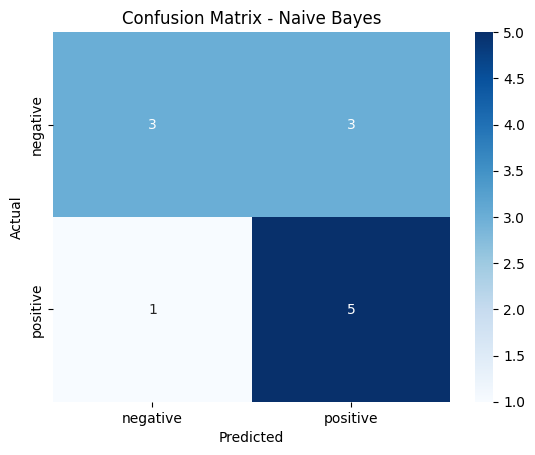

In [48]:
# -------------------------------
# 7. Evaluate All Models
# -------------------------------
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_nb, "Naive Bayes")


In [49]:
# Save models and vectorizer
joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(nb, 'multinomial_naive_bayes_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']